# Normalize track data from Spotify

In Phase 1, we retrieved track data from Spotify and loaded it into a single table:
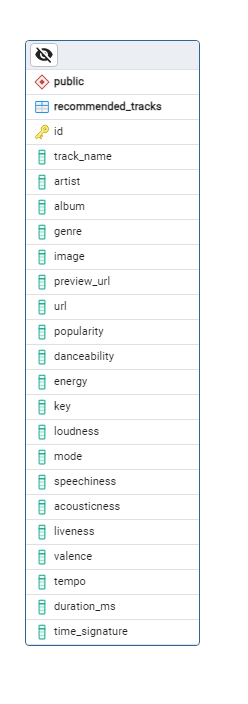

In this Phase 2, we normalize the data to create 4 tables in total: tracks, albums, artists and music_collection. The last table is an association table which links to each of the tables.
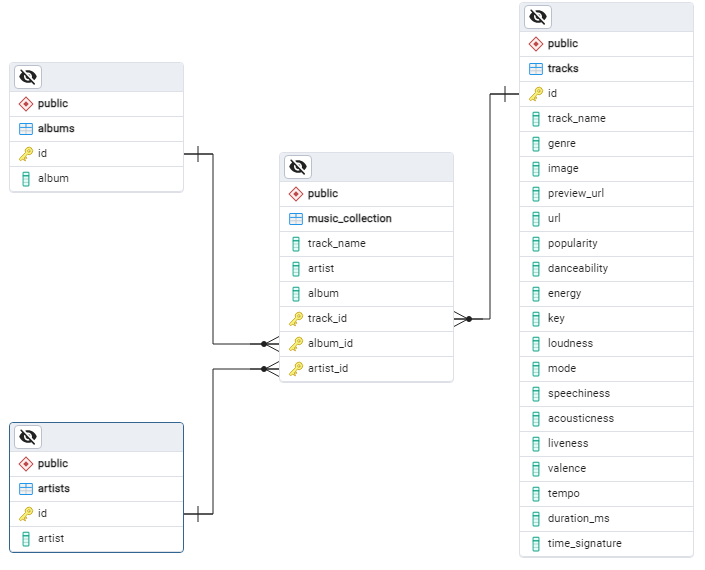

# Import libraries

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import psycopg2
import sqlalchemy as db

# Retrieve data from Spotify, 3 songs for each genre

In [2]:
# Set your Spotify API credentials
client_id = '6c2ff081fe494968a2e3a618c678fd62'
client_secret = '99da4179a82f4f999058535d8d9b47dc'

In [3]:
# Initialize the Spotipy client
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

In [4]:
# Define seed genres
seed_genres = ['anime', 'ambient', 'classical', 'country', 'chill', 'edm', 'folk', 'gospel', 'hip-hop', 'jazz', 'k-pop', 'latin', 'metal', 'pop', 'r-n-b', 'rock']

In [5]:
# Initialize an empty list to store track data
all_track_data = []

In [6]:
for seed_genre in seed_genres:
    recommended_tracks = sp.recommendations(seed_genres=[seed_genre], limit=3, country="SG")
    for track in recommended_tracks["tracks"]:
        track_data = {
            "track_name": track["name"],
            "artist": ", ".join(artist["name"] for artist in track["artists"]),
            "album": track["album"]["name"],
            "genre": seed_genre,
            "image": track["album"]["images"][0]["url"],
            "preview_url": track["preview_url"],
            "url": track['album']['external_urls']['spotify']
        }
        all_track_data.append(track_data)
        
        # Search for individual track by ID to get "popularity".
        track_search = sp.track(track['id'])
        track_data["popularity"] = track_search["popularity"]

        # Search for audio features of track by ID
        audio_features = sp.audio_features(track['id'])[0]
        for key, value in audio_features.items():
            track_data[key] = value

# Convert Spotify data to dataframe and inspect data

In [7]:
# Create a DataFrame from the track data
df = pd.DataFrame(all_track_data)

In [8]:
# Ensure print dataframe with full column width for url display, inspect
pd.set_option('display.max_colwidth', None)  

print(df.head())

                          track_name          artist  \
0                          進めアバンチュール           i☆Ris   
1                   Jiyuu no Tsubasa  Linked Horizon   
2  Departures 〜あなたにおくるアイの歌〜(TV Edit)          EGOIST   
3                               Hush         Subheim   
4                        Dog Shelter          Burial   

                      album    genre  \
0         §Rainbow (TYPE-A)    anime   
1                    自由への進撃    anime   
2  Departures ~あなたにおくるアイの歌~    anime   
3                  Approach  ambient   
4                    Untrue  ambient   

                                                              image  \
0  https://i.scdn.co/image/ab67616d0000b273709472243f70e28cd914f274   
1  https://i.scdn.co/image/ab67616d0000b273212adf5e2d1936a9aed49dd8   
2  https://i.scdn.co/image/ab67616d0000b2734afe1fa4798fc13070d4d1d8   
3  https://i.scdn.co/image/ab67616d0000b273cc21eae0f96b8a586f160a97   
4  https://i.scdn.co/image/ab67616d0000b2736c2e19ba68e459d6c43f4992

In [9]:
# Inspect info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        48 non-null     object 
 1   artist            48 non-null     object 
 2   album             48 non-null     object 
 3   genre             48 non-null     object 
 4   image             48 non-null     object 
 5   preview_url       36 non-null     object 
 6   url               48 non-null     object 
 7   popularity        48 non-null     int64  
 8   danceability      48 non-null     float64
 9   energy            48 non-null     float64
 10  key               48 non-null     int64  
 11  loudness          48 non-null     float64
 12  mode              48 non-null     int64  
 13  speechiness       48 non-null     float64
 14  acousticness      48 non-null     float64
 15  instrumentalness  48 non-null     float64
 16  liveness          48 non-null     float64
 17 

In [10]:
# Check for duplicates
print(df[df.duplicated()])

Empty DataFrame
Columns: [track_name, artist, album, genre, image, preview_url, url, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, id, uri, track_href, analysis_url, duration_ms, time_signature]
Index: []

[0 rows x 26 columns]


In [11]:
# Check if we retrieved all the genres
print(df['genre'].unique())

['anime' 'ambient' 'classical' 'country' 'chill' 'edm' 'folk' 'gospel'
 'hip-hop' 'jazz' 'k-pop' 'latin' 'metal' 'pop' 'r-n-b' 'rock']


In [12]:
# Make a copy to keep original as df
tracks_df = df.copy(deep=True)

In [13]:
# Check artist column and observe multiple values in one column
print(tracks_df['artist'].unique())

['i☆Ris' 'Linked Horizon' 'EGOIST' 'Subheim' 'Burial' 'Marble Sounds'
 'Dmitri Shostakovich, Yuri Torchinsky, Peter Dixon, BBC Philharmonic, Vassily Sinaisky'
 'Iannis Xenakis, Luxembourg Philharmonic Orchestra, Arturo Tamayo'
 'Franz Liszt, Van Cliburn' 'Frankie Ballard' 'Toby Keith' 'Luke Bryan'
 'Passenger' 'Train' 'Paolo Nutini' 'Zedd, Foxes' 'Party Favor' 'Noisses'
 'First Aid Kit' 'Laura Veirs' 'Amos Lee' 'Mary Mary' 'Bebe & Cece Winans'
 'Martha Munizzi' 'Kendrick Lamar, Zacari' 'Plies, Kodak Black' 'Russ'
 'Vernon Duke, Tal Farlow' 'Herbie Hancock' 'Liam Noble' 'Yiruma'
 "Girls' Generation" 'Miryo' 'Intocable' 'Alejandro Fernández'
 'Carlos Rivera' 'Megadeth' 'Van Halen' 'Parkway Drive' 'Trey Songz'
 'Flo Rida' 'Drake, Rihanna' 'Jamie Foxx, Chris Brown'
 'Janelle Monáe, Jidenna' 'Lloyd, Lil Wayne' 'Fame on Fire' 'Heart'
 'Chris Cornell']


# Create 'artists' table

In [14]:
# Split values in 'artist' and create a new DataFrame for artists
artists_df = tracks_df['artist'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
print(artists_df)

0              i☆Ris
1     Linked Horizon
2             EGOIST
3            Subheim
4             Burial
           ...      
44             Lloyd
44         Lil Wayne
45      Fame on Fire
46             Heart
47     Chris Cornell
Length: 63, dtype: object


In [15]:
# Rename 'artist' column and reset index
artists_df = artists_df.rename('artist').reset_index()
print(artists_df)

    index          artist
0       0           i☆Ris
1       1  Linked Horizon
2       2          EGOIST
3       3         Subheim
4       4          Burial
..    ...             ...
58     44           Lloyd
59     44       Lil Wayne
60     45    Fame on Fire
61     46           Heart
62     47   Chris Cornell

[63 rows x 2 columns]


In [16]:
# Drop 'index' column
artists_df = artists_df.drop('index', axis=1)
print(artists_df)

            artist
0            i☆Ris
1   Linked Horizon
2           EGOIST
3          Subheim
4           Burial
..             ...
58           Lloyd
59       Lil Wayne
60    Fame on Fire
61           Heart
62   Chris Cornell

[63 rows x 1 columns]


In [17]:
# Create a unique id for each artist
artists_df.insert(0, 'id', artists_df.index + 1)
print(artists_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      63 non-null     int64 
 1   artist  63 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


# Create albums table

In [18]:
albums_df = tracks_df['album']
print(albums_df.head())

0           §Rainbow (TYPE-A)
1                      自由への進撃
2    Departures ~あなたにおくるアイの歌~
3                    Approach
4                      Untrue
Name: album, dtype: object


In [19]:
albums_df = albums_df.rename('album').reset_index()
print(albums_df.head())

   index                     album
0      0         §Rainbow (TYPE-A)
1      1                    自由への進撃
2      2  Departures ~あなたにおくるアイの歌~
3      3                  Approach
4      4                    Untrue


In [20]:
# Drop index column
albums_df = albums_df.drop('index', axis=1)

In [21]:
# Create a unique id for each artist
albums_df.insert(0, 'id', albums_df.index + 1)
print(albums_df.head())

   id                     album
0   1         §Rainbow (TYPE-A)
1   2                    自由への進撃
2   3  Departures ~あなたにおくるアイの歌~
3   4                  Approach
4   5                    Untrue


# 'Explode' tracks_df

tracks_df has a column 'artist' where we find multiple values in some entries. We need to split up the values and create a new row for each, using the dataframe.explode function. 

In [22]:
tracks_df['artist'] = tracks_df['artist'].str.split(',')
print(tracks_df.head(10))

                                track_name  \
0                                進めアバンチュール   
1                         Jiyuu no Tsubasa   
2        Departures 〜あなたにおくるアイの歌〜(TV Edit)   
3                                     Hush   
4                              Dog Shelter   
5                        The Time To Sleep   
6  The Gadfly Suite, Op. 97: VIII. Romance   
7                                Jonchaies   
8                               Un sospiro   
9                       Sunshine & Whiskey   

                                                                                        artist  \
0                                                                                      [i☆Ris]   
1                                                                             [Linked Horizon]   
2                                                                                     [EGOIST]   
3                                                                                    [Subheim]   
4  

In [23]:
tracks_ex_df = tracks_df.explode('artist')
print(tracks_ex_df.head(15))

                                track_name  \
0                                進めアバンチュール   
1                         Jiyuu no Tsubasa   
2        Departures 〜あなたにおくるアイの歌〜(TV Edit)   
3                                     Hush   
4                              Dog Shelter   
5                        The Time To Sleep   
6  The Gadfly Suite, Op. 97: VIII. Romance   
6  The Gadfly Suite, Op. 97: VIII. Romance   
6  The Gadfly Suite, Op. 97: VIII. Romance   
6  The Gadfly Suite, Op. 97: VIII. Romance   
6  The Gadfly Suite, Op. 97: VIII. Romance   
7                                Jonchaies   
7                                Jonchaies   
7                                Jonchaies   
8                               Un sospiro   

                               artist  \
0                               i☆Ris   
1                      Linked Horizon   
2                              EGOIST   
3                             Subheim   
4                              Burial   
5                

In [24]:
tracks_ex_df = tracks_ex_df.reset_index(drop=True)
print(tracks_ex_df.head(10))

                                track_name               artist  \
0                                進めアバンチュール                i☆Ris   
1                         Jiyuu no Tsubasa       Linked Horizon   
2        Departures 〜あなたにおくるアイの歌〜(TV Edit)               EGOIST   
3                                     Hush              Subheim   
4                              Dog Shelter               Burial   
5                        The Time To Sleep        Marble Sounds   
6  The Gadfly Suite, Op. 97: VIII. Romance  Dmitri Shostakovich   
7  The Gadfly Suite, Op. 97: VIII. Romance      Yuri Torchinsky   
8  The Gadfly Suite, Op. 97: VIII. Romance          Peter Dixon   
9  The Gadfly Suite, Op. 97: VIII. Romance     BBC Philharmonic   

                                                                                album  \
0                                                                   §Rainbow (TYPE-A)   
1                                                                              自由への進

# Create association table taa_df

Now we can create the association table with lists tracks-artists-albums. These can have many-to-many relationships.

In [25]:
taa_df = tracks_ex_df[['track_name', 'artist', 'album', 'id']].copy(deep=True)
print(taa_df)

                           track_name          artist  \
0                           進めアバンチュール           i☆Ris   
1                    Jiyuu no Tsubasa  Linked Horizon   
2   Departures 〜あなたにおくるアイの歌〜(TV Edit)          EGOIST   
3                                Hush         Subheim   
4                         Dog Shelter          Burial   
..                                ...             ...   
58                            Holding           Lloyd   
59                            Holding       Lil Wayne   
60                       Shape of You    Fame on Fire   
61                              Alone           Heart   
62                        The Promise   Chris Cornell   

                       album                      id  
0          §Rainbow (TYPE-A)  6tvkZ3l7Q1YWGNfwEmKFRf  
1                     自由への進撃  188vCXc4bAejLqGhpEVBGT  
2   Departures ~あなたにおくるアイの歌~  6O06qe9TrNRV3ux0KIFg80  
3                   Approach  1asDVE9Cu3YZeIYWPz2dC5  
4                     Untrue  615bAxPCk0

# Copy albums.id into taa

In [26]:
albums_merged_df = pd.merge(albums_df, taa_df, left_on='album', right_on='album', how='left')
print(albums_merged_df.head())

   id_x                     album                         track_name  \
0     1         §Rainbow (TYPE-A)                          進めアバンチュール   
1     2                    自由への進撃                   Jiyuu no Tsubasa   
2     3  Departures ~あなたにおくるアイの歌~  Departures 〜あなたにおくるアイの歌〜(TV Edit)   
3     4                  Approach                               Hush   
4     5                    Untrue                        Dog Shelter   

           artist                    id_y  
0           i☆Ris  6tvkZ3l7Q1YWGNfwEmKFRf  
1  Linked Horizon  188vCXc4bAejLqGhpEVBGT  
2          EGOIST  6O06qe9TrNRV3ux0KIFg80  
3         Subheim  1asDVE9Cu3YZeIYWPz2dC5  
4          Burial  615bAxPCk03PC2sTdK4XPX  


In [27]:
taa_df['album_id'] = albums_merged_df['id_x']
print(taa_df)

                           track_name          artist  \
0                           進めアバンチュール           i☆Ris   
1                    Jiyuu no Tsubasa  Linked Horizon   
2   Departures 〜あなたにおくるアイの歌〜(TV Edit)          EGOIST   
3                                Hush         Subheim   
4                         Dog Shelter          Burial   
..                                ...             ...   
58                            Holding           Lloyd   
59                            Holding       Lil Wayne   
60                       Shape of You    Fame on Fire   
61                              Alone           Heart   
62                        The Promise   Chris Cornell   

                       album                      id  album_id  
0          §Rainbow (TYPE-A)  6tvkZ3l7Q1YWGNfwEmKFRf         1  
1                     自由への進撃  188vCXc4bAejLqGhpEVBGT         2  
2   Departures ~あなたにおくるアイの歌~  6O06qe9TrNRV3ux0KIFg80         3  
3                   Approach  1asDVE9Cu3YZeIYWPz2dC5   

# Copy artists.id into taa

In [28]:
artists_merged_df = pd.merge(artists_df, taa_df, left_on='artist', right_on='artist', how='left')
print(artists_merged_df)

    id_x          artist                         track_name  \
0      1           i☆Ris                          進めアバンチュール   
1      2  Linked Horizon                   Jiyuu no Tsubasa   
2      3          EGOIST  Departures 〜あなたにおくるアイの歌〜(TV Edit)   
3      4         Subheim                               Hush   
4      5          Burial                        Dog Shelter   
..   ...             ...                                ...   
58    59           Lloyd                            Holding   
59    60       Lil Wayne                                NaN   
60    61    Fame on Fire                       Shape of You   
61    62           Heart                              Alone   
62    63   Chris Cornell                        The Promise   

                       album                    id_y  album_id  
0          §Rainbow (TYPE-A)  6tvkZ3l7Q1YWGNfwEmKFRf       1.0  
1                     自由への進撃  188vCXc4bAejLqGhpEVBGT       2.0  
2   Departures ~あなたにおくるアイの歌~  6O06qe9TrNRV3ux0KI

In [29]:
taa_df['artist_id'] = artists_merged_df['id_x']
print(taa_df)

                           track_name          artist  \
0                           進めアバンチュール           i☆Ris   
1                    Jiyuu no Tsubasa  Linked Horizon   
2   Departures 〜あなたにおくるアイの歌〜(TV Edit)          EGOIST   
3                                Hush         Subheim   
4                         Dog Shelter          Burial   
..                                ...             ...   
58                            Holding           Lloyd   
59                            Holding       Lil Wayne   
60                       Shape of You    Fame on Fire   
61                              Alone           Heart   
62                        The Promise   Chris Cornell   

                       album                      id  album_id  artist_id  
0          §Rainbow (TYPE-A)  6tvkZ3l7Q1YWGNfwEmKFRf         1          1  
1                     自由への進撃  188vCXc4bAejLqGhpEVBGT         2          2  
2   Departures ~あなたにおくるアイの歌~  6O06qe9TrNRV3ux0KIFg80         3          3  
3          

In [30]:
# Rename 'id' column from original table, which refers to track_id
taa_df = taa_df.rename(columns={'id': 'track_id'})

In [31]:
print(list(taa_df.columns))

['track_name', 'artist', 'album', 'track_id', 'album_id', 'artist_id']


# Clean up tracks_df

In [32]:
# Remove artist and album from tracks_df
tracks_df = tracks_df.drop(['artist', 'album'], axis=1)

In [33]:
# Pop 'id' column, and insert into the front, to designate as primary key in table
cols = list(tracks_df)
cols.insert(0, cols.pop(cols.index('id')))  
tracks_df = tracks_df[cols]

# Check after done
print(tracks_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                48 non-null     object 
 1   track_name        48 non-null     object 
 2   genre             48 non-null     object 
 3   image             48 non-null     object 
 4   preview_url       36 non-null     object 
 5   url               48 non-null     object 
 6   popularity        48 non-null     int64  
 7   danceability      48 non-null     float64
 8   energy            48 non-null     float64
 9   key               48 non-null     int64  
 10  loudness          48 non-null     float64
 11  mode              48 non-null     int64  
 12  speechiness       48 non-null     float64
 13  acousticness      48 non-null     float64
 14  instrumentalness  48 non-null     float64
 15  liveness          48 non-null     float64
 16  valence           48 non-null     float64
 17 

In [34]:
# Drop 'type', 'uri', 'track_href', 'analysis_url' columns
tracks_df.drop(columns=['type', 'uri', 'track_href', 'analysis_url'], inplace=True)
print(tracks_df.head(2))

                       id        track_name  genre  \
0  6tvkZ3l7Q1YWGNfwEmKFRf         進めアバンチュール  anime   
1  188vCXc4bAejLqGhpEVBGT  Jiyuu no Tsubasa  anime   

                                                              image  \
0  https://i.scdn.co/image/ab67616d0000b273709472243f70e28cd914f274   
1  https://i.scdn.co/image/ab67616d0000b273212adf5e2d1936a9aed49dd8   

                                                                                                   preview_url  \
0  https://p.scdn.co/mp3-preview/d28888d519ea7fee01925ac68def80033a329bb4?cid=6c2ff081fe494968a2e3a618c678fd62   
1  https://p.scdn.co/mp3-preview/677ac8656e5b4bc4f2fcb21b52617fe1db5a71df?cid=6c2ff081fe494968a2e3a618c678fd62   

                                                     url  popularity  \
0  https://open.spotify.com/album/5vdFJBY9qep4YWWLTn3xI2           5   
1  https://open.spotify.com/album/31L6jyQkVDu1xdfXizvAc2          59   

   danceability  energy  key  loudness  mode  speechiness  acou

# Connect to DB , create tables and load data into DB

In [41]:
# Connect to PostgreSQL database
db_params = {
    "host": "rain.db.elephantsql.com",
    "dbname": "auspovuc",  # Replace with your desired database name
    "user": "auspovuc",  # Replace with your PostgreSQL username
    "password": "bmJdG19Daw9rkEsJ3VnkefRGCBF_oy7F",  # Replace with your PostgreSQL password
}
conn = psycopg2.connect(**db_params)
cur = conn.cursor()

In [36]:
# Create a table tracks
cur.execute("""
    CREATE TABLE IF NOT EXISTS tracks (
        id VARCHAR PRIMARY KEY,
        track_name VARCHAR,
        genre VARCHAR,
        image VARCHAR,
        preview_url VARCHAR,
        url VARCHAR,
        popularity SMALLINT,
        danceability FLOAT,
        energy FLOAT,
        key SMALLINT,
        loudness FLOAT,
        mode SMALLINT,
        speechiness FLOAT,
        acousticness FLOAT,
        liveness FLOAT, 
        valence FLOAT,
        tempo FLOAT,
        duration_ms INT,
        time_signature SMALLINT
    )
""")
conn.commit()

In [37]:
# # Insert data into the table
for _, row in tracks_df.iterrows():
    cur.execute("""
        INSERT INTO tracks (id, track_name, genre, image, preview_url, url, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, liveness, valence, tempo, duration_ms, time_signature)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, (row["id"], row["track_name"], row["genre"], row["image"], row["preview_url"], row["url"], row["popularity"], row["danceability"], row["energy"], row["key"], row["loudness"], row["mode"], row["speechiness"], row["acousticness"], row["liveness"], row["valence"], row["tempo"], row["duration_ms"], row["time_signature"]))

conn.commit()

In [42]:
# Create a table artists
cur.execute("""
    CREATE TABLE IF NOT EXISTS artists (
        id INT PRIMARY KEY,
        artist VARCHAR
    )
""")
conn.commit()

In [43]:
# Insert data into the table
for _, row in artists_df.iterrows():
    cur.execute("""
        INSERT INTO artists (id, artist)
        VALUES (%s, %s)
    """, (row["id"],row["artist"]))
conn.commit()

In [44]:
# Create a table albums
cur.execute("""
    CREATE TABLE IF NOT EXISTS albums (
        id INT PRIMARY KEY,
        album VARCHAR
    )
""")
conn.commit()

In [45]:
# Insert data into the table
for _, row in albums_df.iterrows():
    cur.execute("""
        INSERT INTO albums (id, album)
        VALUES (%s, %s)
    """, (row["id"],row["album"]))
conn.commit()

In [46]:
# Create a table taa
cur.execute("""
    CREATE TABLE IF NOT EXISTS music_collection (
        track_name VARCHAR,
        artist VARCHAR,
        album VARCHAR,
        track_id VARCHAR NOT NULL,
        album_id INT NOT NULL,
        artist_id INT NOT NULL,
        PRIMARY KEY(track_id, album_id, artist_id)
    )
""")
conn.commit()

In [47]:
# Insert data into the table taa
for _, row in taa_df.iterrows():
    cur.execute("""
        INSERT INTO music_collection (track_name, artist, album, track_id, album_id, artist_id)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, (row["track_name"], row["artist"], row["album"], row["track_id"], row["album_id"], row["artist_id"]))
conn.commit()

In [48]:
# Close connection
conn.close()

These are the tables created after the data has been normalized:

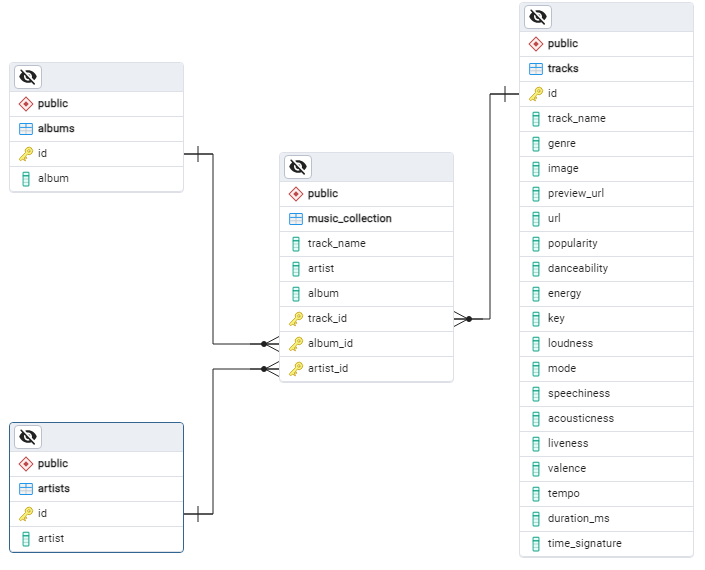